## TP Detección de fraude
Dataset de kaggle

In [51]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import accuracy_score,plot_confusion_matrix,roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc


In [11]:
fraud_dataset = pd.read_csv('./data/PS_20174392719_1491204439457_log.csv')

In [12]:
fraud_dataset.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0

* step: represents a unit of time where 1 step equals 1 hour
* type: type of online transaction
* amount: the amount of the transaction
* nameOrig: customer starting the transaction
* oldbalanceOrg: balance before the transaction
* newbalanceOrig: balance after the transaction
* nameDest: recipient of the transaction
* oldbalanceDest: initial balance of recipient before the transaction
* newbalanceDest: the new balance of recipient after the transaction
* isFraud: fraud transaction

In [13]:
fraud_dataset.shape

(6362620, 11)

In [14]:
#Chequear si hay nulos
fraud_dataset.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
#Dtype de las columnas
fraud_dataset.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

### Distribución de variables

/Users/mtaglio/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='step', ylabel='Density'>

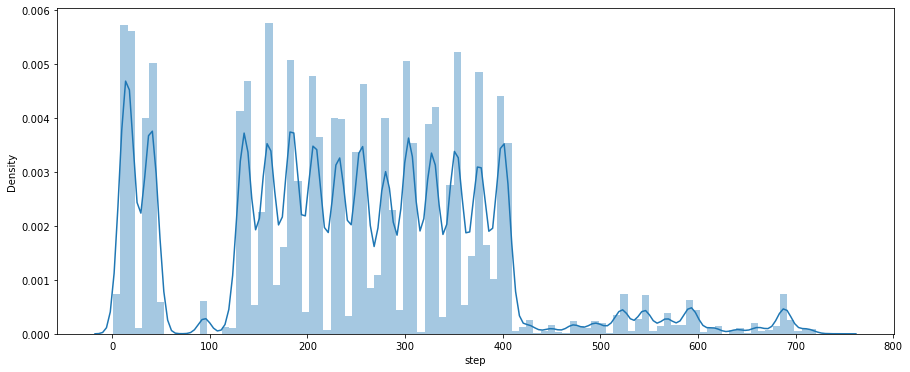

In [26]:
fraud_dataset['step'].value_counts()
plt.figure(figsize=(15,6))
sns.distplot(fraud_dataset['step'],bins=100)

In [15]:
print('Distribución de la variable type')
print(fraud_dataset['type'].value_counts())

type = fraud_dataset.type.value_counts()
transaction = type.index
quantity = type.values

figure = px.pie(fraud_dataset,
               values = quantity,
               names = transaction,
               hole = .3,
               title = 'Distribución de la variable type')
figure.show()

Distribución de la variable type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


<AxesSubplot:xlabel='type', ylabel='amount'>

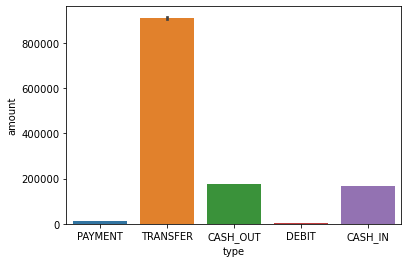

In [9]:
sns.barplot(x='type',y='amount',data=fraud_dataset)

La transacción con más observaciones es CASH_OUT seguida de PAYMENT.  Las operaciones con montos más altos son de tipo TRANSFER.

/Users/mtaglio/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



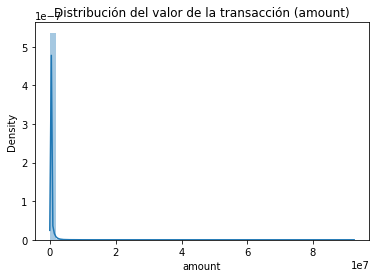

In [19]:
fraud_dataset['amount'].value_counts()
fig = plt.figure()
sns.distplot(fraud_dataset['amount'])
plt.title('Distribución del valor de la transacción (amount)')
plt.show(fig)

Distribución asimétrica negativa (left-skewed).

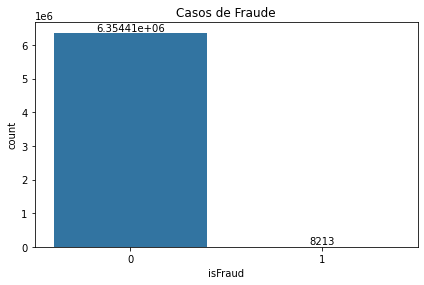

In [21]:
#Distribución variable de salida isFraud
fig = plt.figure()
ax = sns.countplot(x='isFraud', data=fraud_dataset)
for container in ax.containers:
    ax.bar_label(container)
plt.tight_layout()
plt.title('Casos de Fraude')
plt.show(fig)


In [27]:
fraud_dataset['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

Aproximadamente un 0,13% de las transacciones fueron clasificadas como fraude. Como se puede ver en el gráfico el dataset no está balanceado.

### Correlaciones

<AxesSubplot:>

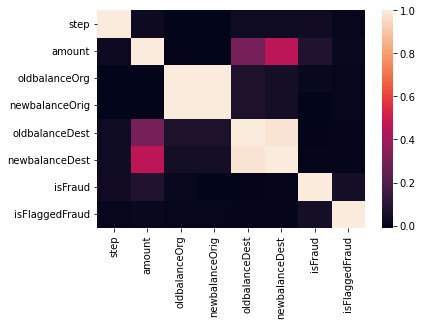

In [34]:
#Chequear correlaciones de las features con la variable de salida isFraud
heatmap(fraud_dataset.corr())

In [24]:
fraud_dataset.corr().unstack().sort_values(ascending=False).drop_duplicates()

step            step              1.000000
oldbalanceOrg   newbalanceOrig    0.998803
newbalanceDest  oldbalanceDest    0.976569
                amount            0.459304
amount          oldbalanceDest    0.294137
                isFraud           0.076688
newbalanceOrig  oldbalanceDest    0.067812
oldbalanceDest  oldbalanceOrg     0.066243
isFraud         isFlaggedFraud    0.044109
oldbalanceOrg   newbalanceDest    0.042029
newbalanceDest  newbalanceOrig    0.041837
step            isFraud           0.031578
                oldbalanceDest    0.027665
                newbalanceDest    0.025888
                amount            0.022373
isFlaggedFraud  amount            0.012295
isFraud         oldbalanceOrg     0.010154
isFlaggedFraud  oldbalanceOrg     0.003835
newbalanceOrig  isFlaggedFraud    0.003776
isFlaggedFraud  step              0.003277
newbalanceDest  isFraud           0.000535
oldbalanceDest  isFlaggedFraud   -0.000513
isFlaggedFraud  newbalanceDest   -0.000529
amount     

Hay correlación alta entre oldbalanceOrg y newbalanceOrg y entre oldbalanceDest y newbalanceDest.

### Distribución de las transacciones fraudulentas por tipo

<AxesSubplot:xlabel='isFraud', ylabel='count'>

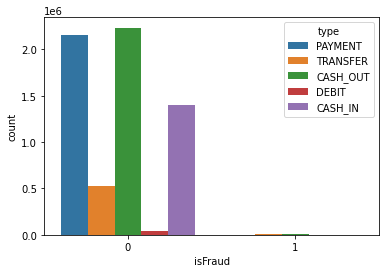

In [33]:
sns.countplot(x='isFraud',data=fraud_dataset,hue='type')

Las transacciones de tipo CASH_OUT y PAYMENT concentran la mayor cantidad de fraude.

### Preparación de datos

Variables categóricas: type, nameOrig, nameDest, isFraud, isFlaggedFraud, 
Variables numéricas: amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest, step

In [35]:
fraud_dataset.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0

In [36]:
type_new = pd.get_dummies(fraud_dataset['type'],drop_first=True)

In [37]:
fraud_dataset = pd.concat([fraud_dataset,type_new],axis=1)

In [38]:
fraud_dataset.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  \
0  M1979787155             0.0             0.0        0               0   
1  M2044282225             0.0             0.0        0               0   
2   C553264065             0.0             0.0        1               0   
3    C38997010         21182.0             0.0        1               0   
4  M1230701703             0.0             0.0        0               0   

   CASH_OUT  DEBIT  PAYMENT  TRANSFER  
0         0      0        1         0  
1         0      0        1         0  
2         0      0        0         1  
3         1      0        0         0  
4         0      0        1         0

### Train baseline model

In [41]:
X = fraud_dataset[['step','CASH_OUT','DEBIT','PAYMENT','TRANSFER','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']]
y= fraud_dataset['isFraud']

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [44]:
from sklearn.linear_model import LogisticRegression

In [45]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [46]:
lr_preds = lr.predict(X_test)

In [47]:
accuracy_score(y_test, lr_preds)

0.9983256373422689

In [50]:
print(classification_report(y_test, lr_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.37      0.43      0.40      2435

    accuracy                           1.00   1908786
   macro avg       0.68      0.72      0.70   1908786
weighted avg       1.00      1.00      1.00   1908786



### Balancear el dataset

In [52]:
#chequear presencia de cada clase y tamaño
print('Entrenamiento:',X_train.shape)
print('Testeo:',X_test.shape)
print('\nClases train:')
print(y_train.value_counts(normalize=True))
print('\nClases test:')
print(y_test.value_counts(normalize=True))

Entrenamiento: (4453834, 10)
Testeo: (1908786, 10)

Clases train:
0    0.998703
1    0.001297
Name: isFraud, dtype: float64

Clases test:
0    0.998724
1    0.001276
Name: isFraud, dtype: float64


#### 1. Logistic regression CV: con optimización LBGFS

In [55]:
from sklearn.linear_model import LogisticRegressionCV

In [73]:
def logistic_regression_report(X_train,X_test,y_train,y_test):
       
    model=LogisticRegressionCV(scoring='f1')
    
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    y_proba=model.predict_proba(X_test)
    
    print(classification_report(y_test,y_pred))
    
    print('Area bajo la curva ROC:',np.round(roc_auc_score(y_test,y_proba[:,1]),4))
    
    precision, recall,threshold=precision_recall_curve(y_test,y_proba[:,1]);

    print('Area bajo la curva Precision-Recall:',np.round(auc(recall,precision),4))

    plot_confusion_matrix(model,X_test,y_test,cmap='Blues');

    return
    

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.37      0.43      0.40      2435

    accuracy                           1.00   1908786
   macro avg       0.68      0.72      0.70   1908786
weighted avg       1.00      1.00      1.00   1908786

Area bajo la curva ROC: 0.885
Area bajo la curva Precision-Recall: 0.4112


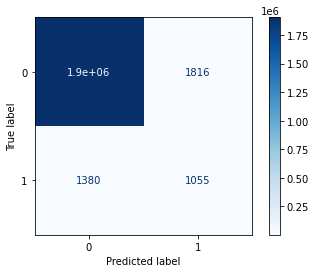

In [74]:
logistic_regression_report(X_train, X_test, y_train, y_test)

In [ ]:
#grid search de Logistic regression

Resultados con Logistic Regression con optimización lbfgs: 
* bajo recall: bajo porcentaje de casos que cubrimos con nuestra clasificación de la transacción como fraude.
* baja precisión: bajo porcentaje del total de casos que acertamos cuando decimos que una transacción es fraude.

Resultados con Logistic Regression con optimización newton-cg: 


#### 2. Undersampling

In [61]:
from imblearn.under_sampling import RandomUnderSampler


In [63]:
#selecciono número de muestras igual al de la clase minoritaria
undersampler = RandomUnderSampler(sampling_strategy = "majority")
X_train_us, y_train_us = undersampler.fit_resample(X_train, y_train)

print("training set con undersampling")
print(y_train_us.value_counts())
print()
print("Test set con undersampling")
print(y_test.value_counts())

training set con undersampling
0    5778
1    5778
Name: isFraud, dtype: int64

Test set con undersampling
0    1906351
1       2435
Name: isFraud, dtype: int64


              precision    recall  f1-score   support

           0       1.00      0.91      0.95   1906351
           1       0.01      0.89      0.02      2435

    accuracy                           0.91   1908786
   macro avg       0.51      0.90      0.49   1908786
weighted avg       1.00      0.91      0.95   1908786

Area bajo la curva ROC: 0.9572
Area bajo la curva Precision-Recall: 0.5295


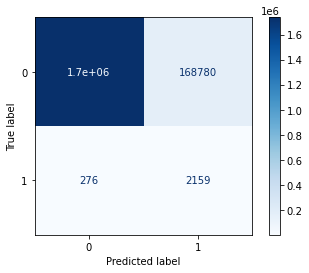

In [64]:
logistic_regression_report(X_train_us, X_test, y_train_us, y_test)

Resultados con undersampling: 
* alta cobertura o recall, o sea mayor porcentaje de casos que cubrimos con nuestra clasificación de la transacción como fraude.

* baja precisión: el porcentaje del total de casos que acertamos cuando decimos que una transacción es fraude.

El modelo es bueno prediciendo los casos que no son fraude, pero tiene poca precisión cuando se trata de acertar los casos que sí fueron etiquetados como fraude. Esto es, es más probable que los clasifique como si no fueran fraude. 
Es importante evitar errores de este tipo (falsos negativos) para poder capturar la mayor cantidad de transacciones que son verdaderamente fraudulentas y no dejarlas pasar. 

#### 3. Oversampling

Resultados con oversampling: